In [ ]:
# load in the eta data

In [ ]:
# fit to just y
import numpy as np
from pysr import PySRRegressor






datafile = np.load("toyproblem_noisy_sr_data_4.npz")

skip = 1
finish = 3000

X = datafile["theta"][::skip, :]
y = datafile["eta"][::skip, :]
∂y = datafile["jacobians"][::skip, :, :]



# choose which variable to do

idx = 0


model = PySRRegressor(
    niterations=500,  # < Increase me for better results
    binary_operators=["+", "*", "pow", "/"],
    unary_operators=[
        "log",
        "sqrt",
        # ^ Custom operator (julia syntax)
    ],
    constraints={'pow': (-1, 1), 
                             '*': (3, 3)},

    batch_size=30,
    equation_file = "eta%d.csv"%(idx)
    #extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    #loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)
model.fit(X, y[:, idx])

In [1]:
# next calculate the jacobians of the found expressions

# need some flattening criteria (should we do the fisher or just the dot of the Jacs ?)

In [2]:
!pip install -q jax jaxlib


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [51]:
import sympy
import numpy as np
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import pysr

import os,glob


θs = jnp.array(np.load("toy_problem_regression_outputs.npz")["theta"])
Fs = jnp.array(np.load("toy_problem_regression_outputs.npz")["F_network"])

def load_eta_component(index, parentdir, final=False,
                      model_selection="score"):
    if final:
       list_of_files = glob.glob(parentdir + 'eta%d.pkl'%(index))
    else:
      list_of_files = glob.glob(parentdir + 'eta%d.csv'%(index))
    latest_file = max(list_of_files, key=os.path.getmtime)

    model = PySRRegressor.from_file(latest_file)
    model.model_selection = model_selection
    
    return model



def apply_jax_model(theta, model):
       jax_model = model.jax()
       app = lambda d: jax_model["callable"](d, jax_model["parameters"])
       return app(theta)


# grab all the models in jax format and get the gradients

def get_Jeta(theta, models):
    
  def eta(t):
    t = t[jnp.newaxis, :]
    eta_ = jnp.stack([
                apply_jax_model(t, models[0]),
                apply_jax_model(t, models[1]),
                #apply_jax_model(t, models[2]),
                #apply_jax_model(t, models[3]),
                #apply_jax_model(t, models[4]),
                #apply_jax_model(t, models[5])
                ], -1)
    return eta_

  return jnp.squeeze((jax.jacrev(eta))(theta))



def get_F_eta_sr(models, F_theta, theta):
  """returns F_eta, J_eta with specified models"""
  def fn(F, t):
    Jeta = get_Jeta(t, models)
    Jetainv = jnp.linalg.inv(Jeta)#, hermitian=False)

    return Jetainv.T @ F @ Jetainv, Jeta

  return jax.vmap(fn)(F_theta, theta)

# def get_F_eta_sr(models, F_theta, theta):
#   """returns F_eta, J_eta with specified models"""
#   def fn(F, t):
#     Jeta = get_Jeta(t, models)
#     #Jetainv = jnp.linalg.inv(Jeta)#, hermitian=False)

#     return Jeta.T @ Jeta, Jeta

#   return jax.vmap(fn)(F_theta, theta)

def get_F_eta_single(model, F_theta, theta):
  """returns F_eta, J_eta with specified single pySR model"""
  def fn(F, t):
    Jeta = get_Jeta_single(t, model)
    Jetainv = jnp.linalg.inv(Jeta) #, hermitian=False)

    return Jetainv.T @ F @ Jetainv, Jeta

  return jax.vmap(fn)(F_theta, theta)

In [129]:
θs.shape, Fs.shape

((10000, 2), (10000, 2, 2))

In [149]:
n_params = 2

models = [load_eta_component(i, parentdir="./", model_selection="best") for i in range(n_params)]

Checking if ./eta0.pkl exists...
Loading model from ./eta0.pkl
Checking if ./eta1.pkl exists...
Loading model from ./eta1.pkl


In [150]:
[m.sympy() for m in models]

[(-23.8504181908475*x0 + log(x1))/(x1**0.79251546 + 1.0280411) - 56.794834,
 x0**2 + x0/x1**x1 + log(x1**6.637196) + 170.40056]

In [151]:
Fetas, Jetas = get_F_eta_sr(models, Fs, θs)

In [152]:
jnp.linalg.det(jnp.mean(Fetas, 0))

Array(1.9234128, dtype=float32)

In [156]:
jnp.mean(jnp.linalg.det((Fetas)))

Array(1.8876219, dtype=float32)

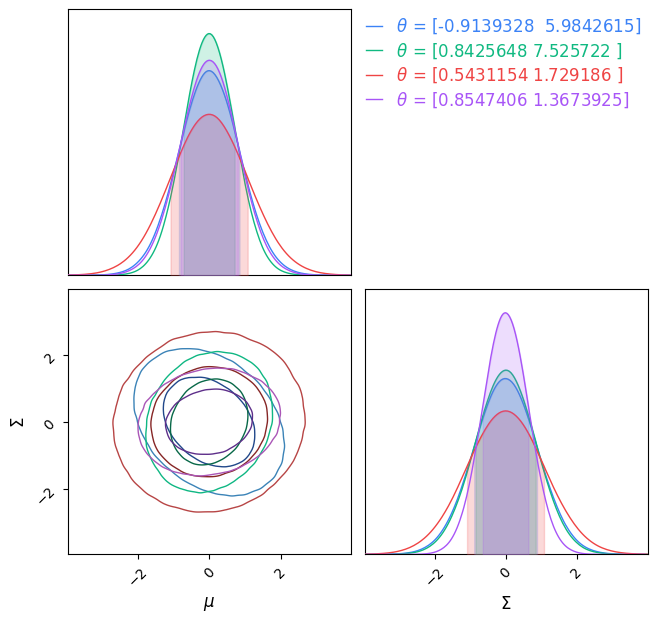

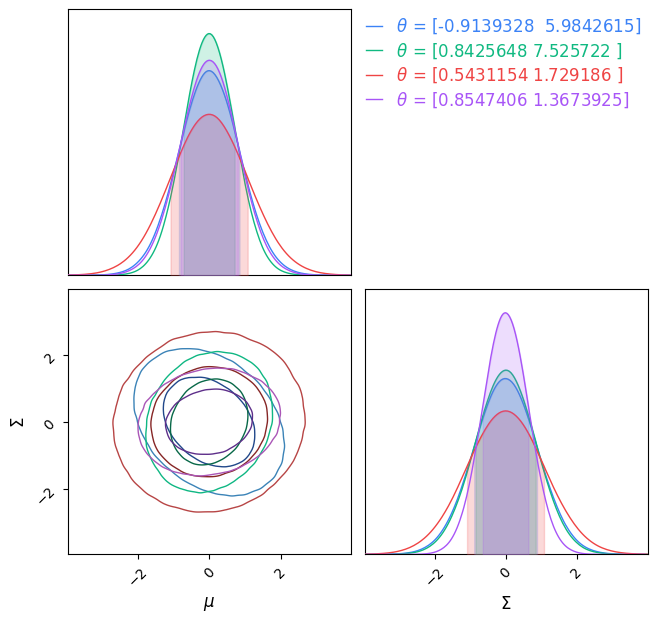

In [157]:
from chainconsumer import ChainConsumer, Chain
cs = ChainConsumer()

indx = [3,59,67,130]

for i in indx:
    
    name = r"$\theta$ = " + str(θs[i])

    chain = Chain.from_covariance(
        np.zeros(n_params),
        np.linalg.inv(Fetas[i]),
        columns=[r'$\mu$', r'$\Sigma$'],
        name=name,
        #color="#065f46",
        #linestyle=":",
        shade_alpha=0.0
    )
    cs.add_chain(chain)

cs.plotter.plot((7,7))

In [14]:
!pip install -q chainconsumer


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
